In [1]:
import numpy as np
import emcee
import re
import corner
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
from tqdm.autonotebook import tqdm
from multiprocessing import Pool

# import own modules
import functions as func
from data_structures import ObsData, LightCurve, PartialLightCurve
from mcmc import ln_prob, ln_prior, ln_posterior, theor_curve

/tmp/ipykernel_1531639/302410145.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# get state vectors of the Earth and the Sun from JPL Horizons database
asteroid_name = "2000 WO107" 

In [3]:
lightcurve = LightCurve()  # container to store partial lightcurves
earth_data = ObsData()     # store earth vectors
sun_data = ObsData()       # store sun vectors

In [4]:
# get names of the lightcurve files
fnames = [f for f in os.listdir('light_curves') if re.match(r'.*\.dat', f)]
fnames.sort()

In [5]:
# read and parse partial lightcurve files
for fname in fnames[:4]:
    part_curve = pd.read_fwf(f'light_curves/{fname}', header=None, names=['epoch', 'mag', 'mag_err'])
    lightcurve += PartialLightCurve(part_curve)
for fname in fnames[4:]:
    part_curve = pd.read_csv(f'light_curves/{fname}', header=None, names=['epoch', 'mag', 'mag_err'], sep='\t')
    part_curve['epoch'] = part_curve['epoch'].astype(float) + 2400000.5
    lightcurve += PartialLightCurve(part_curve)

In [6]:
# sort lightcurves in the ascending order of the epoch
lightcurve.sort_lightcurves()
start_epoch = lightcurve.joined['epoch'].min()
reduc_epochs = lightcurve.joined['epoch'] - start_epoch

In [7]:
len(lightcurve.joined)

1741

In [8]:
# query JPL Horizons to get state vectors of the Sun and the Earth
for part_curve in tqdm(lightcurve, total=len(lightcurve), desc='Querying JPL Horizons'):
    epochs = part_curve.data.epoch.to_list()
    state_vecs_sun = func.get_object_orbit(asteroid_name, epochs=epochs,  location='@10', data_type='vectors') 
    # @399 - Earth
    state_vecs_earth = func.get_object_orbit(asteroid_name, epochs=epochs,  location='@399', data_type='vectors') 
    # calculate reduc epoch (counting from start epoch)
    state_vecs_sun['reduc_epoch'] = state_vecs_sun['epoch'] - start_epoch
    state_vecs_earth['reduc_epoch'] = state_vecs_earth['epoch'] - start_epoch
    # inverse signs of vectors
    state_vecs_sun[['x', 'y', 'z']] = -state_vecs_sun[['x', 'y', 'z']]
    state_vecs_earth[['x', 'y', 'z']] = -state_vecs_earth[['x', 'y', 'z']]
    sun_data += state_vecs_sun
    earth_data += state_vecs_earth

Querying JPL Horizons:   0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
lightcurve.save_data('input_data/lightcurve_data.csv')
sun_data.save_data('input_data/state_vecs_sun.csv')
earth_data.save_data('input_data/state_vecs_earth.csv')


In [10]:
sun_data2 = ObsData()
sun_data2.load_data('sun_data.csv')

In [10]:
# some starting parameters of the binary 
#a1, b1, c1, a2, b2, c2, lon, lat, init_phase = params
params = [1.51, 0.553, 0.572, 0.747, 0.716, 1.488, 0.814, 2.789, 1.193]
params = [1.5, 0.97/1.5, 1.5/1.5, 0.57/1.5, 0.97/1.5, 1.12/1.5, 0.36, 1.57, 0.48]
lightcurve_theor = theor_curve(params=params, earth_data=earth_data, sun_data=sun_data)
# calculate how much the part of the observational curve have to be shifted up/down
lightcurve.calculate_shifts(other=lightcurve_theor)
# shift observed data (lightcurves) by the amount of vertical shift
lightcurve.shift_curves()

χ^2_part6 = 4167.7,
χ^2 total = 1575870.4


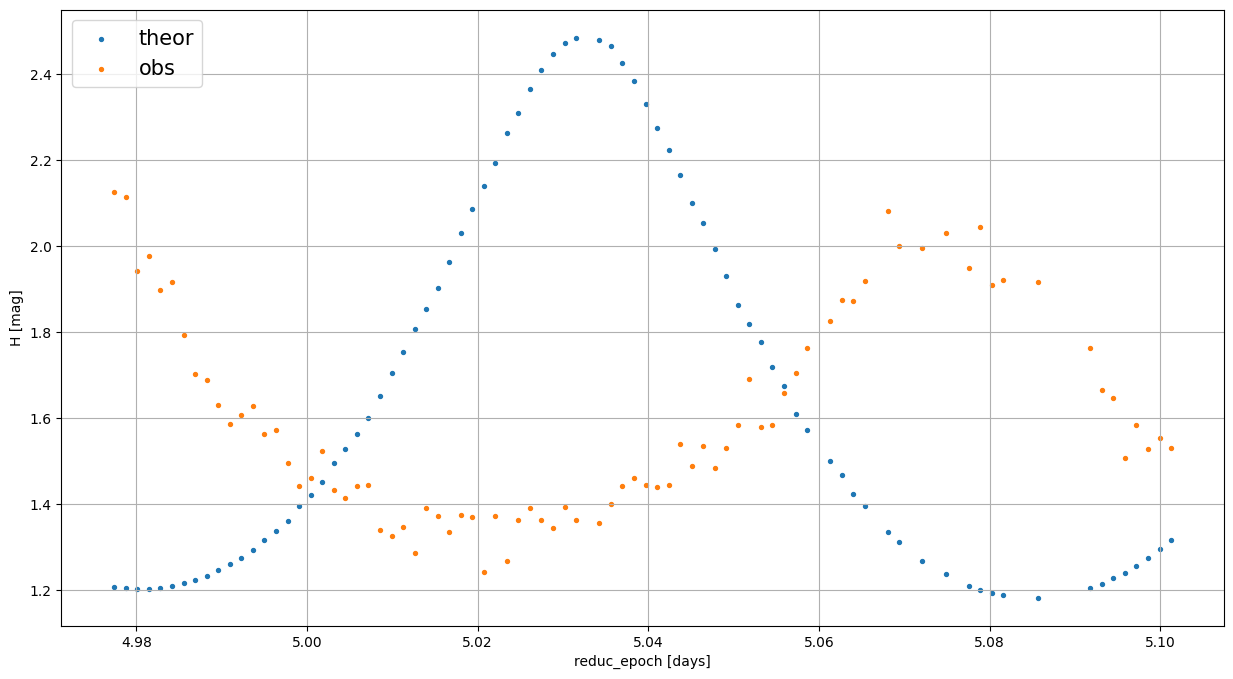

In [11]:
plt.figure(figsize=(15, 8))
idx = 6
lc = lightcurve.lightcurves[idx].data
plt.scatter(sun_data[idx]['reduc_epoch'], lightcurve_theor[idx], s=8, label='theor')
plt.scatter(sun_data[idx]['reduc_epoch'], lightcurve.lightcurves[idx].data['mag_shifted'], s=8, label='obs')

plt.xlabel('reduc_epoch [days]')
plt.ylabel('H [mag]')
plt.legend(loc='upper left', prop = { "size": 15 })
plt.grid()
# calculate chi-squared
chi2_part = np.sum((lc['mag_shifted'] 
               - lightcurve_theor[idx]) ** 2 / lc['mag_err']  ** 2)
# calculate chi-squared
chi2 = np.sum((lightcurve.joined['mag_shifted'] 
               - lightcurve_theor.joined) ** 2 / lightcurve.joined['mag_err'] ** 2)
print(f"\u03C7^2_part{idx} = {chi2_part:.1f},\n\u03C7^2 total = {chi2:.1f}") 

χ^2 = 12558.5


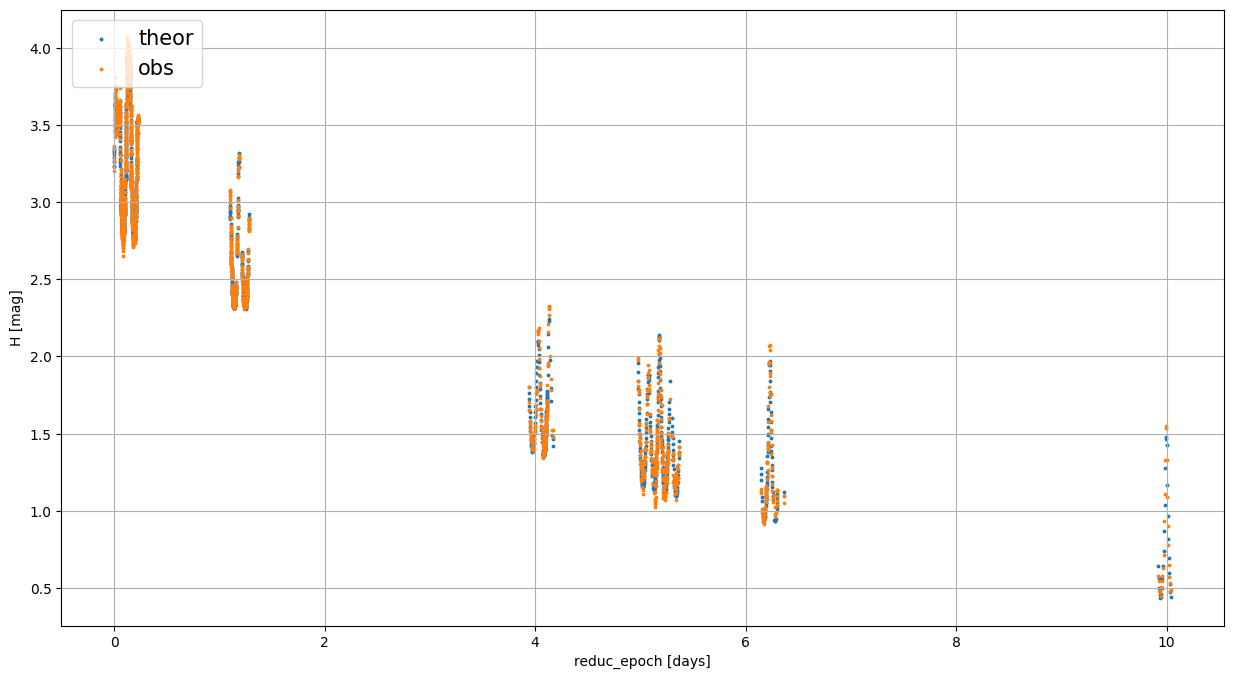

In [12]:
plt.figure(figsize=(15, 8))
plt.scatter(reduc_epochs, lightcurve_theor.joined, s=3, label='theor')
plt.scatter(reduc_epochs, lightcurve.joined['mag_shifted'], s=3, label='obs')

plt.xlabel('reduc_epoch [days]')
plt.ylabel('H [mag]')
plt.legend(loc='upper left', prop = { "size": 15 })
plt.grid()
# calculate chi-squared
chi2 = np.sum((lightcurve.joined['mag_shifted'] 
               - lightcurve_theor.joined) ** 2 / lightcurve.joined['mag_err'] ** 2)
print(f"\u03C7^2 = {chi2:.1f}")

In [13]:
n_procs = 6  # number of processes (cores) to use
nwalkers = 18  # number of probe points

# without a1
coeff = 0.1
init_ps = [0.97/1.5, 1.5/1.5, 0.57/1.5, 0.97/1.5, 1.12/1.5, 0.36, 1.57, 0.48]
init_params = np.array([init_ps[0]  + coeff * np.random.randn(nwalkers),  # b1
                        init_ps[1]  + coeff * np.random.randn(nwalkers),  # c1
                        init_ps[2]  + coeff * np.random.randn(nwalkers),  # a2
                        init_ps[3]  + coeff * np.random.randn(nwalkers),  # b2
                        init_ps[4]  + coeff * np.random.randn(nwalkers),  # c2
                        0 + np.random.uniform(low=0, high=2 * math.pi, size=nwalkers), 
                        0 + np.random.uniform(low=-math.pi /2, high=math.pi /2, size=nwalkers), 
                        0 + np.random.uniform(low=0, high=2 * math.pi, size=nwalkers)]).T
ndim = np.size(init_params, axis=1)  # number of parameters
print(ndim)
init_params = init_params.astype(float)

8


In [26]:
with Pool(processes=n_procs) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, 
                                    args=(lightcurve, earth_data, sun_data), 
                                    pool=pool)
    # Run the MCMC sampler
    nsteps = 50
    burn_in = 2
    # starting points for every walker
    #init_p = np.random.rand(nwalkers, ndim)
    pos, prob, state = sampler.run_mcmc(init_params, nsteps, progress=True)
    # Get the samples after burn-in
    samples = sampler.get_chain(discard=burn_in, flat=True)

# Plot the scatter plot of data and fitted model
best_fit_params = np.median(samples, axis=0)
best_fit_params = np.insert(best_fit_params, 0, 1.0)
fit_curve = theor_curve(best_fit_params, earth_data, sun_data)

  0%|          | 0/50 [00:00<?, ?it/s]/home/igor/anaconda3/envs/sandbox/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


In [29]:
func.estimate_density(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.02)

AttributeError: module 'functions' has no attribute 'estimate_density'

In [17]:
import pickle
file_pick = open('lc_mcmc_27_08.obj', 'rb')
sampler = pickle.load(file_pick)

In [18]:
samples_flat = sampler.flatchain
samples = sampler.get_chain(flat=True)
flat_ln = sampler.flatlnprobability #[np.isfinite(sampler.flatlnprobability)]
min_arg = flat_ln.argmax()
min_chi = flat_ln[min_arg]
print(f"min_arg: {min_arg}, min_chi: {min_chi}")
best_params = samples_flat[min_arg]
print(np.shape(samples))


# Calculate the quantile
quant = 0.5
threshold = np.quantile(flat_ln, q=quant)
print(f"threshold q={quant}: ln_posterior = {threshold}")
# Get the indices of the values that are in the specified quantile
indices = np.where(flat_ln >= threshold)[0]
# calculate best-fit parameters as a median of q=0.95 least chi2 results 
#best_med_params = np.median(samples_flat[indices], axis=0)
best_med_params = samples_flat[indices][0]
best_params = samples_flat[min_arg]

print("""best_params: a1 = 1.0  b1 = {:.2f}, c1 = {:.2f},
             a2 = {:.2f}, b2 = {:.2f}, c2 = {:.2f}, 
             lon = {:.2f}, lat = {:.2f}, phase = {:.2f}""".format(*best_params))
best_params = np.insert(best_params, 0, 1.0)
best_med_params = np.insert(best_med_params, 0, 1.0)
best_params_list = list(best_params)
best_params_list = [round(param, 3) for param in best_params_list]
best_med_params_list = [round(param, 3) for param in best_med_params]
print('best:      ', best_params_list)
print(f'best q={quant}:', best_med_params_list)

min_arg: 1186999, min_chi: -6199.587870301344
(1200000, 8)
threshold q=0.5: ln_posterior = -6522.925047082879
best_params: a1 = 1.0  b1 = 0.54, c1 = 0.42,
             a2 = 0.68, b2 = 0.67, c2 = 0.67, 
             lon = 5.08, lat = -1.34, phase = 5.49
best:       [1.0, 0.544, 0.424, 0.676, 0.673, 0.673, 5.079, -1.336, 5.493]
best q=0.5: [1.0, 0.858, 0.855, 0.999, 0.672, 0.505, 5.019, -1.357, 2.291]


In [19]:
print("Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.023


/tmp/ipykernel_612533/3583923755.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1, h_pad=-0.4, w_pad=0.5)


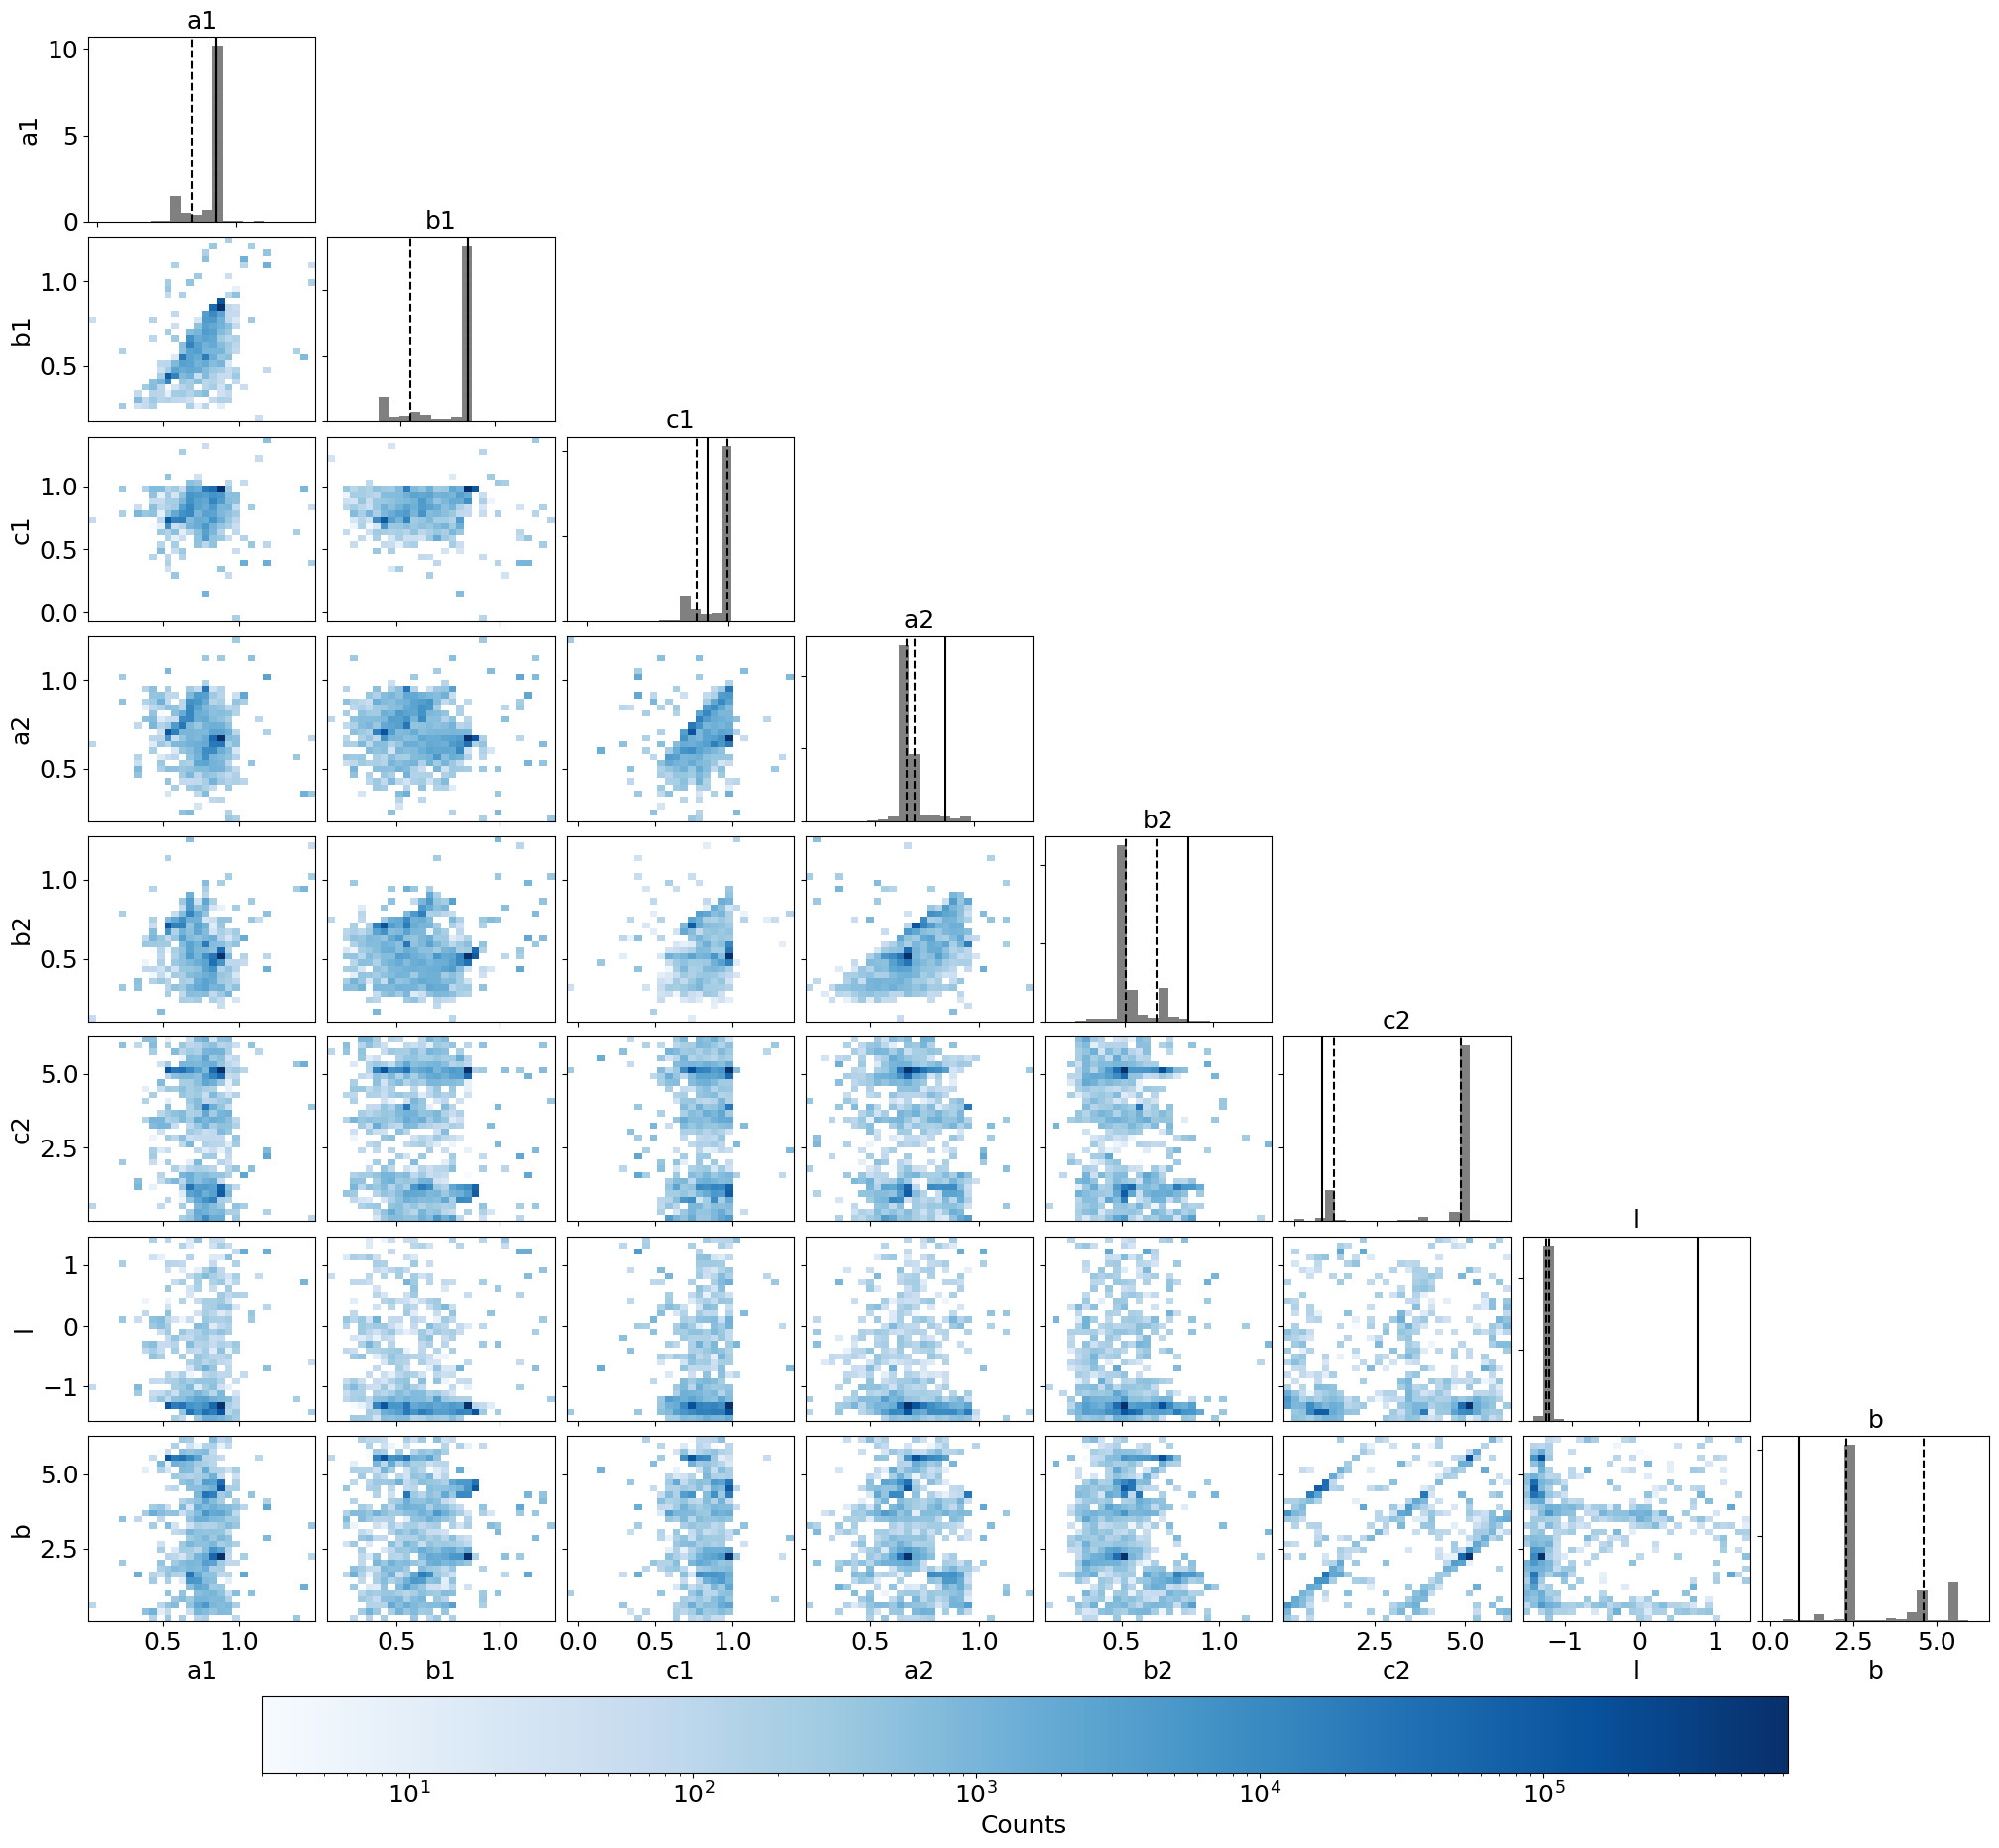

In [67]:
# Number of parameters
from matplotlib.colors import LogNorm
data = samples
num_params = data.shape[1]
labels=["a1", "b1", "c1", "a2", "b2", "c2", "l", "b", "phi0"]

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
# Create a figure with subplots
fig, axes = plt.subplots(num_params, num_params, figsize=(20, 20), dpi=100)
bins_heat = 30
bins_hist = 20

# Variable to store the mappable object for the colorbar
mappable = None
# Plot the histograms and scatter plots
for i in range(num_params):
    for j in range(num_params):
        if i < j:
            # Skip the upper triangle and diagonal
            axes[i, j].axis('off')
        elif i == j:
            # Diagonal: plot histograms
            axes[i, j].hist(data[:, i], bins=bins_hist, color='gray', density=True)
            p16 = np.percentile(data[:, i], 16)
            p84 = np.percentile(data[:, i], 84)
            median = np.median(data)
            axes[i, j].axvline(median, color='black')
            axes[i, j].axvline(p16, color='black', linestyle='--')
            axes[i, j].axvline(p84, color='black', linestyle='--')
            # Add title with median and percentiles
            # axes[i, j].title.set_text(r'{0}=${1}^{2}$_{3}$'.format(labels[i], 
            #                                                        round(median,2), round(p16, 2), round(p84, 2)))
            axes[i, j].title.set_text(labels[i])
        else:
            # Off-diagonal: plot scatter plots
            h = axes[i, j].hist2d(data[:, j], data[:, i], bins=bins_heat, cmap='Blues', norm=LogNorm())
            if mappable is None:
                mappable = h[3]  # Store the mappable object for the colorbar
            #axes[i, j].set_xlabel(labels[j])
           
        # Remove labels for cleaner look
        if i < num_params - 1:
            axes[i, j].set_xticklabels([])
        if j > 0:
            axes[i, j].set_yticklabels([])
        
        # Add axis labels
        if i == num_params - 1:
            axes[i, j].set_xlabel(labels[j])
        if j == 0:
            axes[i, j].set_ylabel(labels[i])


# Add a colorbar at the bottom for all subplots
if mappable:
    cbar = fig.colorbar(mappable, ax=axes, orientation='horizontal', fraction=0.05, pad=-0.25, shrink=2.0)
    cbar.set_label('Counts')

# Adjust layout
plt.tight_layout(pad=0.1, h_pad=-0.4, w_pad=0.5)
plt.show()

<Figure size 640x480 with 0 Axes>

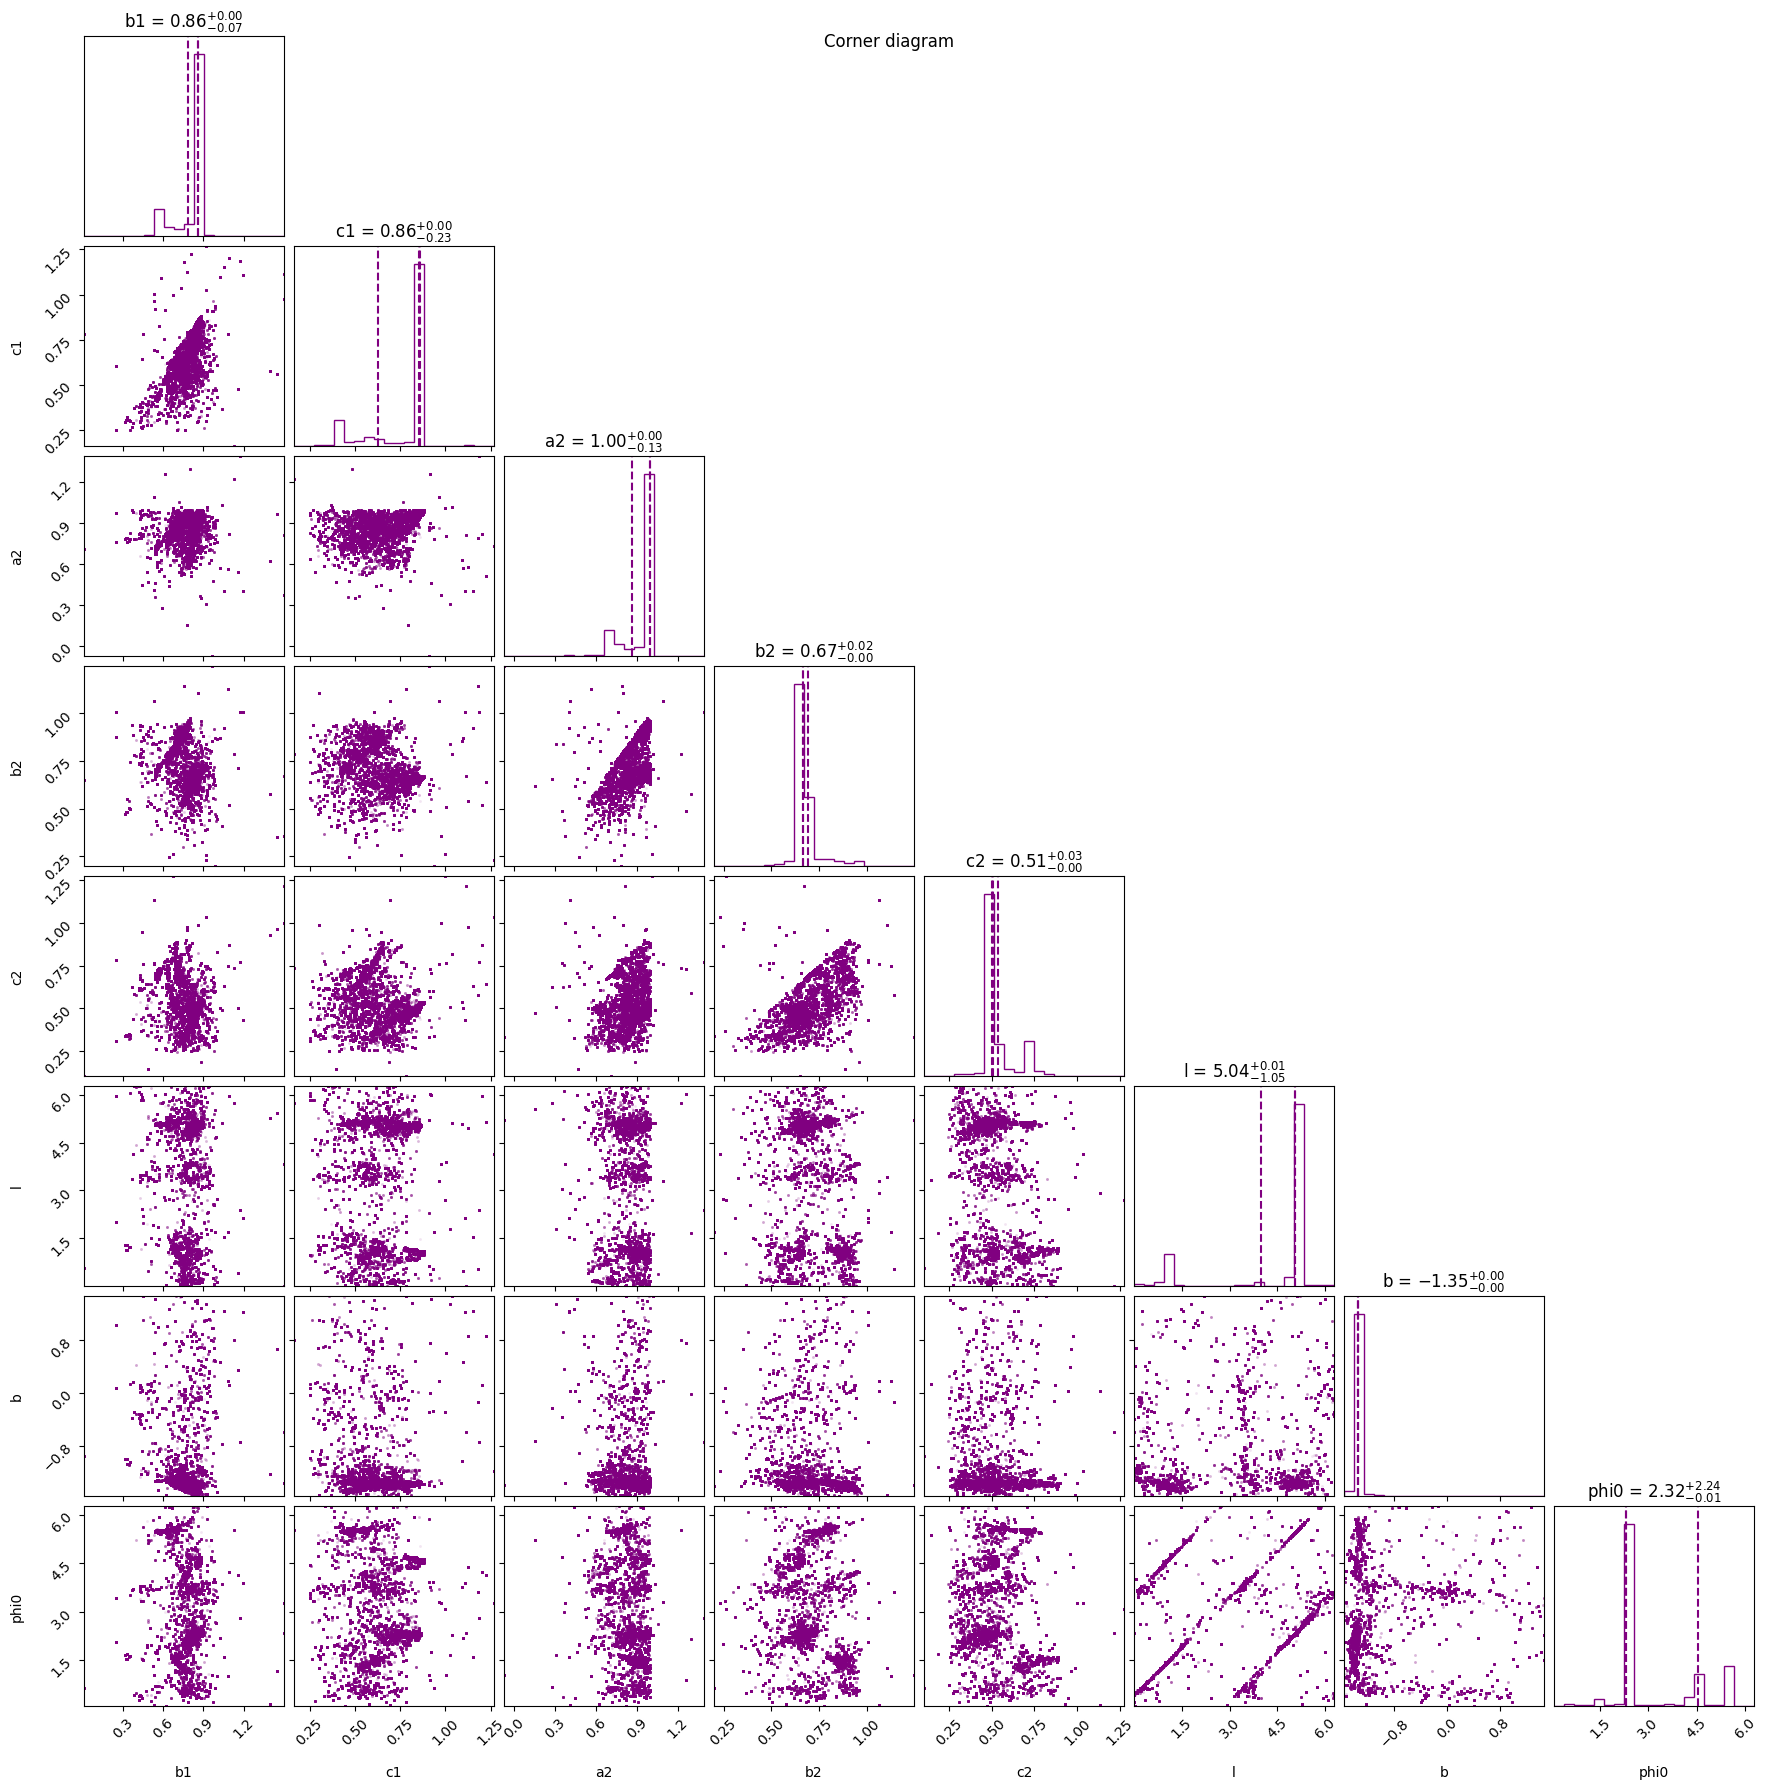

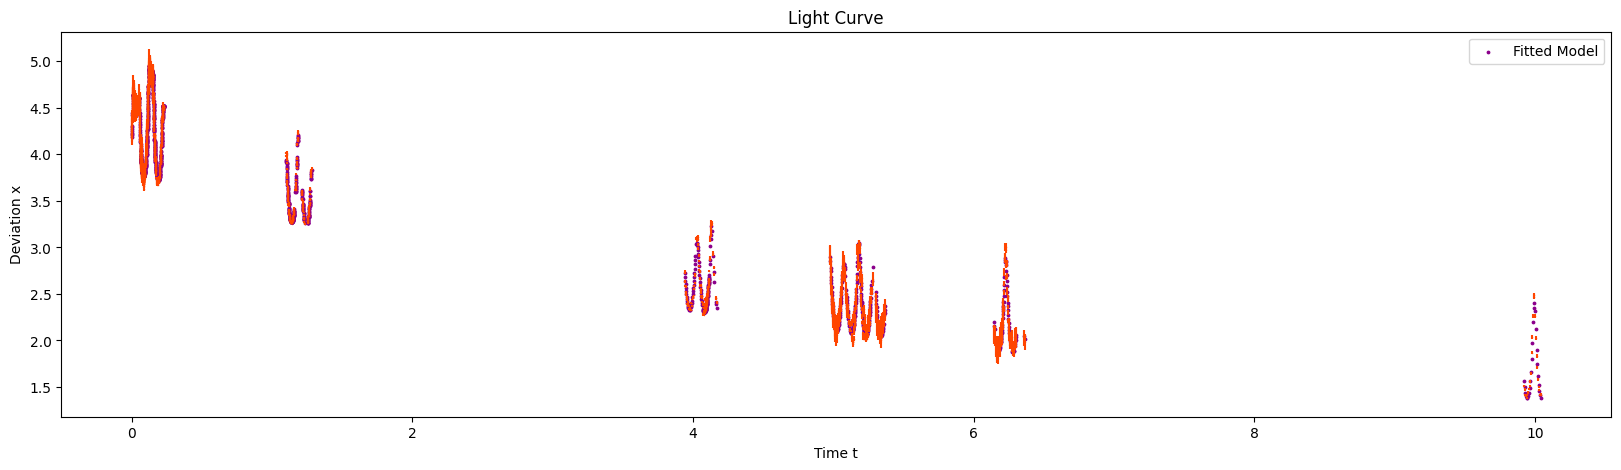

In [20]:
# Plot the corner plot
plt.figure()

corner_fig = corner.corner(samples, labels=["b1", "c1", "a2", "b2", "c2", "l", "b", "phi0"], quantiles=[0.2, 0.5, 0.8], show_titles=True, title_kwargs={"fontsize": 12}, plot_contours=False, fill_contours=False, plot_density=False, color="purple", levels=[0.1, 0.5, 1.], title_fmt=".2f")
plt.suptitle("Corner diagram") 

fit_curve = theor_curve(best_params, earth_data, sun_data)


lightcurve.calculate_shifts(other=fit_curve)
lightcurve.shift_curves()

plt.figure(figsize=(20, 5))
plt.errorbar(reduc_epochs, lightcurve.joined['mag_shifted'], yerr=lightcurve.joined['mag_err'], fmt='o', color='orangered', markersize=0.1)
plt.scatter(reduc_epochs, fit_curve.joined, label='Fitted Model', color='darkmagenta', s=3)
plt.xlabel('Time t')
plt.ylabel('Deviation x')
plt.title("Light Curve")
plt.legend()

χ^2_part0 = 1044.6,
χ^2 total = 12399.2


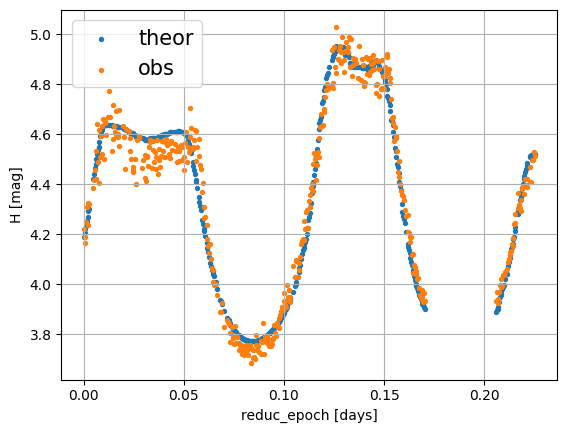

In [21]:
## plt.figure(figsize=(15, 8))
idx = 0
lc_theor = theor_curve(params=best_params, earth_data=earth_data, sun_data=sun_data)

lightcurve.calculate_shifts(other=lc_theor)
lightcurve.shift_curves()
lc = lightcurve.lightcurves[idx].data

plt.scatter(sun_data[idx]['reduc_epoch'], lc_theor[idx], s=8, label='theor')
plt.scatter(sun_data[idx]['reduc_epoch'], lightcurve.lightcurves[idx].data['mag_shifted'], s=8, label='obs')

plt.xlabel('reduc_epoch [days]')
plt.ylabel('H [mag]')
plt.legend(loc='upper left', prop = { "size": 15 })
plt.grid()
# calculate chi-squared
chi2_part = np.sum((lc['mag_shifted'] 
               - lc_theor[idx]) ** 2 / lc['mag_err']  ** 2)
# calculate chi-squared
chi2 = np.sum((lightcurve.joined['mag_shifted'] 
               - lc_theor.joined) ** 2 / lightcurve.joined['mag_err'] ** 2)
print(f"\u03C7^2_part{idx} = {chi2_part:.1f},\n\u03C7^2 total = {chi2:.1f}") 

In [463]:
# import pickle
# file_pick = open('2ndbest_sampler_constrained.obj', 'wb')
#pickle.dump(sampler, file=file_pick)
# file_pick = open('best_sampler.obj', 'rb')
# pickle.load(file_pick).__dict__

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, HBox, VBox, widgets, Layout

# Define the function to update the plot
def interactive_plot(a1=1, b1=1, c1=1, a2=1, b2=1, c2=1, lon=0, lat=0, init_phase=0, x_start=-1, x_end=10, y_start=0, y_end=10):
    params = [a1, b1, c1, a2, b2, c2, lon, lat, init_phase]
    x = reduc_epochs
    fit_curve = theor_curve(params, earth_data, sun_data)
    y = fit_curve.joined
    lightcurve.calculate_shifts(other=fit_curve)
    lightcurve.shift_curves()
    plt.figure(figsize=(15, 5))
    plt.scatter(x, y, s=3, label='theor', alpha=0.5)
    plt.scatter(x, lightcurve.joined['mag_shifted'] , s=3, label='obs', alpha=0.5)
    plt.xlabel('Epoch [days]')
    plt.ylabel('H [mag]')
    plt.title('Interactive plot')
    plt.grid(True)
    plt.legend()
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    # calculate chi-squared
    chi2 = np.sum((lightcurve.joined['mag_shifted']  - y) ** 2 / lightcurve.joined['mag_err']   ** 2)
    print(f"chi2 = {chi2}")
    plt.show()


ps = [1.502, 0.973, 1.5, 0.569, 0.968, 1.121, 0.133, -0.964, 0.412]
ps = [1.0, 1.371, 1.71, 1.945, 1.204, 2.491, 5.103, -1.153, 2.394]
width_sliders = Layout(width='400px')
# Create sliders
a1_slider = widgets.FloatSlider(value=ps[0], min=0, max=3.0, step=0.01, description='a1', layout=width_sliders)
b1_slider = widgets.FloatSlider(value=ps[1], min=0, max=3.0, step=0.01, description='b1', layout=width_sliders)
c1_slider = widgets.FloatSlider(value=ps[2], min=0, max=3.0, step=0.01, description='c1', layout=width_sliders)
a2_slider = widgets.FloatSlider(value=ps[3], min=0, max=3.0, step=0.01, description='a2', layout=width_sliders)
b2_slider = widgets.FloatSlider(value=ps[4], min=0, max=3.0, step=0.01, description='b2', layout=width_sliders)
c2_slider = widgets.FloatSlider(value=ps[5], min=0, max=3.0, step=0.01, description='c2', layout=width_sliders)
lon_slider = widgets.FloatSlider(value=ps[6], min=0, max=np.pi * 2, step=0.01, description='lon', layout=width_sliders)
lat_slider = widgets.FloatSlider(value=ps[7], min=-np.pi/2, max=np.pi/2, step=0.01, description='lat', layout=width_sliders)
init_phase_slider = widgets.FloatSlider(value=ps[8], min=0, max=np.pi * 2, step=0.01, description='init_phase', layout=width_sliders)
x_start_slider = widgets.FloatSlider(value=reduc_epochs.min(), min=reduc_epochs.min() - 1, max=reduc_epochs.max(), step=0.01, description='x_start', layout=width_sliders)
x_end_slider = widgets.FloatSlider(value=reduc_epochs.max(), min=0, max=reduc_epochs.max(), step=0.01, description='x_end', layout=width_sliders)
y_start_slider = widgets.FloatSlider(value=0, min=-5, max=10, step=0.01, description='y_start', layout=width_sliders)
y_end_slider = widgets.FloatSlider(value=6, min=0, max=20, step=0.01, description='y_end', layout=width_sliders)

# Group sliders in two columns
left_box = VBox([a1_slider, b1_slider, c1_slider, a2_slider, b2_slider, c2_slider])
right_box = VBox([lon_slider, lat_slider, init_phase_slider, x_start_slider, x_end_slider, y_start_slider, y_end_slider])

# Make interactive widget
ui = HBox([left_box, right_box])
out = interactive(interactive_plot, a1=a1_slider, b1=b1_slider, c1=c1_slider, a2=a2_slider, b2=b2_slider, c2=c2_slider, lon=lon_slider, lat=lat_slider, init_phase=init_phase_slider, x_start=x_start_slider, x_end=x_end_slider, y_start=y_start_slider, y_end=y_end_slider)
# # Display the interactive plot
display(ui, out.children[-1])

Output()

In [42]:
# get the values of the selected parameters 
params_selected = [out.children[i].value for i in range(0, 9)]
print(params_selected)

[1.5, 0.9699999999999999, 1.5, 0.57, 0.9699999999999999, 1.1199999999999999, 0.36, 1.5707963267948966, 0.48]
